In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize 
from typing import List, Optional
import seaborn as sns

# =============================================================================
# Satellite Constellation Optimization with Multi-Constraints
# =============================================================================


In [40]:
# Setup my utitlity functions

def great_circle_distance(lat1, lon1, lat2, lon2):
    """calculates great circle (angluar) distancce between two geographical coorindates"""
    lat1_rad, lon1_rad, lat2_rad, lon2_rad = map(np.radians, [lat1, lon1, lat2, lon2])

    x1 = np.cos(lat1_rad) * np.cos(lon1_rad)
    y1 = np.cos(lat1_rad) * np.sin(lon1_rad) 
    z1 = np.sin(lat1_rad)

    x2 = np.cos(lat2_rad) * np.cos(lon2_rad)
    y2 = np.cos(lat2_rad) * np.sin(lon2_rad) 
    z2 = np.sin(lat2_rad)

    # dot product of the two vectors is the cos of the angle between the two coordinates
    dot_product = x1*x2 + y1*y2 + z1*z2
    angular_distance = np.arccos(max(-1, min(1, dot_product))) # force beetween 0 and 1 for numeric stability

    return angular_distance

def spherical_coverage_overlap(lat1, lon1, lat2, lon2):
    """calulate the overlap to optimise coverage"""

    angular_distance = great_circle_distance(lat1, lon1, lat2, lon2)

    overlap = np.cos(angular_distance/2)

    return max(0,overlap)

def explonential_signal_decay(distance, decay_constant = 8000):
    """Create exponential decay function for the communication matrix"""
    communication_quality = np.exp(-distance/decay_constant)
    return communication_quality

# Cool satellite name generator

def generate_satellite_names(n_satellites: int, theme: str = "space") -> List[str]:
    """
    Generate cool satellite names for matrix labeling.
    
    Args:
        n_satellites: Number of names to generate
        theme: Theme for names ("space", "mythological", "explorers", "stars", "mixed")
        
    Returns:
        List of satellite names
    """
    
    name_themes = {
        "space": [
            "Aurora", "Nebula", "Cosmos", "Stellar", "Orbital", "Phoenix", "Quantum",
            "Eclipse", "Voyager", "Pioneer", "Discovery", "Endeavour", "Atlantis",
            "Apollo", "Artemis", "Orion", "Galileo", "Kepler", "Hubble", "Spitzer",
            "Chandra", "Cassini", "Juno", "Perseverance", "Curiosity", "Spirit",
            "Opportunity", "Pathfinder", "Ranger", "Surveyor", "Explorer", "Mariner"
        ],
        
        "mythological": [
            "Zeus", "Athena", "Apollo", "Artemis", "Hermes", "Poseidon", "Hera",
            "Ares", "Aphrodite", "Hephaestus", "Demeter", "Dionysus", "Persephone",
            "Hades", "Thor", "Odin", "Freya", "Loki", "Balder", "Frigg",
            "Tyr", "Heimdall", "Vidar", "Vali", "Ra", "Isis", "Osiris",
            "Anubis", "Thoth", "Horus", "Bastet", "Sekhmet"
        ],
        
        "explorers": [
            "Magellan", "Columbus", "Drake", "Cook", "Shackleton", "Amundsen",
            "Scott", "Hillary", "Tenzing", "Lewis", "Clark", "Polo", "Vespucci",
            "Cabral", "Vasco", "Hudson", "Balboa", "Cortez", "Pizarro",
            "Livingstone", "Stanley", "Burton", "Speke", "Park", "Bruce",
            "Ross", "Franklin", "Peary", "Byrd", "Cousteau", "Earhart", "Lindbergh"
        ],
        
        "stars": [
            "Sirius", "Vega", "Altair", "Deneb", "Rigel", "Betelgeuse", "Aldebaran",
            "Antares", "Spica", "Pollux", "Regulus", "Adhara", "Shaula", "Bellatrix",
            "Elnath", "Miaplacidus", "Alnilam", "Alnair", "Alioth", "Dubhe",
            "Alkaid", "Mizar", "Alcor", "Polaris", "Capella", "Arcturus",
            "Canopus", "Procyon", "Achernar", "Hadar", "Acrux", "Gacrux"
        ],
        
        "mixed": []  # Will combine all themes
    }
    
    if theme == "mixed":
        all_names = []
        for theme_names in name_themes.values():
            if theme_names:  # Skip empty mixed list
                all_names.extend(theme_names)
        available_names = all_names
    else:
        available_names = name_themes.get(theme, name_themes["space"])
    
    if n_satellites <= len(available_names):
        # Select unique names
        selected_names = np.random.choice(available_names, n_satellites, replace=False).tolist()
    else:
        # Use all available names and add numbered versions
        selected_names = available_names.copy()
        remaining = n_satellites - len(available_names)
        
        for i in range(remaining):
            base_name = available_names[i % len(available_names)]
            selected_names.append(f"{base_name}-{(i // len(available_names)) + 2}")
    
    return selected_names

# Satellite position generators and utilities

def generate_satellite_positions(n_satellites: int, distribution: str = "global", min_separation: float = 30.0, seed: int = None) -> np.ndarray:
    """
    Generate satellite positions for testing different matrix configurations.
    
    Args:
        n_satellites: Number of satellites to generate
        distribution: Type of distribution ("global", "regional", "clustered", "uniform", "predefined")
        min_separation: Minimum angular separation in degrees (for non-clustered distributions)
        seed: Random seed for reproducibility
        
    Returns:
        np.ndarray: Array of (lat, lon) coordinates
    """
    if seed is not None:
        np.random.seed(seed)
    
    if distribution == "predefined":
        return get_predefined_positions(n_satellites)
    elif distribution == "global":
        return generate_global_positions(n_satellites, min_separation)
    elif distribution == "regional":
        return generate_regional_positions(n_satellites, min_separation)
    elif distribution == "clustered":
        return generate_clustered_positions(n_satellites)
    elif distribution == "uniform":
        return generate_uniform_positions(n_satellites, min_separation)
    else:
        raise ValueError(f"Unknown distribution: {distribution}")

def get_predefined_positions(n_satellites: int) -> np.ndarray:
    """Get predefined positions for major cities worldwide"""
    
    # Major cities with good global distribution
    predefined_cities = {
        1: [(0.0, 0.0)],  # Equator/Prime Meridian
        2: [(51.5074, -0.1278), (-33.8688, 151.2093)],  # London, Sydney
        3: [(13.7563, 100.5018), (-26.2041, 28.0473), (-33.8688, 151.2093)],  # Bangkok, Johannesburg, Sydney
        4: [(40.7128, -74.0060), (51.5074, -0.1278), (35.6762, 139.6503), (-33.8688, 151.2093)],  # NYC, London, Tokyo, Sydney
        5: [(40.7128, -74.0060), (51.5074, -0.1278), (55.7558, 37.6176), (1.3521, 103.8198), (-33.8688, 151.2093)],  # NYC, London, Moscow, Singapore, Sydney
        6: [(40.7128, -74.0060), (51.5074, -0.1278), (55.7558, 37.6176), (1.3521, 103.8198), (-33.8688, 151.2093), (-22.9068, -43.1729)],  # + Rio
        7: [(40.7128, -74.0060), (51.5074, -0.1278), (55.7558, 37.6176), (1.3521, 103.8198), (-33.8688, 151.2093), (-22.9068, -43.1729), (19.4326, -99.1332)],  # + Mexico City
        8: [(40.7128, -74.0060), (51.5074, -0.1278), (55.7558, 37.6176), (1.3521, 103.8198), (-33.8688, 151.2093), (-22.9068, -43.1729), (19.4326, -99.1332), (-26.2041, 28.0473)]  # + Johannesburg
    }
    
    if n_satellites in predefined_cities:
        return np.array(predefined_cities[n_satellites])
    else:
        # For larger numbers, use the 8-city base and add random global positions
        base_positions = np.array(predefined_cities[8])
        additional = generate_global_positions(n_satellites - 8, min_separation=20.0)
        return np.vstack([base_positions, additional])

def generate_global_positions(n_satellites: int, min_separation: float) -> np.ndarray:
    """Generate globally distributed positions with minimum separation"""
    positions = []
    max_attempts = 1000
    
    for i in range(n_satellites):
        attempts = 0
        while attempts < max_attempts:
            # Random position on sphere
            lat = np.arcsin(2 * np.random.random() - 1) * 180 / np.pi  # Uniform on sphere
            lon = (np.random.random() * 2 - 1) * 180
            
            # Check minimum separation from existing positions
            if len(positions) == 0:
                positions.append([lat, lon])
                break
            
            min_dist = min([great_circle_distance(lat, lon, pos[0], pos[1]) * 180/np.pi 
                           for pos in positions])
            
            if min_dist >= min_separation:
                positions.append([lat, lon])
                break
            
            attempts += 1
        
        if attempts >= max_attempts:
            print(f"Warning: Could not maintain {min_separation}° separation for satellite {i+1}")
            positions.append([lat, lon])
    
    return np.array(positions)

def generate_regional_positions(n_satellites: int, min_separation: float) -> np.ndarray:
    """Generate positions within a regional area (e.g., Europe/North Africa)"""
    # Center around Europe/Mediterranean
    center_lat, center_lon = 45.0, 10.0
    region_radius = 30.0  # degrees
    
    positions = []
    max_attempts = 1000
    
    for i in range(n_satellites):
        attempts = 0
        while attempts < max_attempts:
            # Random position within region
            angle = np.random.random() * 2 * np.pi
            radius = np.sqrt(np.random.random()) * region_radius
            
            lat = center_lat + radius * np.cos(angle)
            lon = center_lon + radius * np.sin(angle)
            
            # Clamp to valid ranges
            lat = max(-90, min(90, lat))
            lon = max(-180, min(180, lon))
            
            # Check minimum separation
            if len(positions) == 0:
                positions.append([lat, lon])
                break
            
            min_dist = min([great_circle_distance(lat, lon, pos[0], pos[1]) * 180/np.pi 
                           for pos in positions])
            
            if min_dist >= min_separation:
                positions.append([lat, lon])
                break
            
            attempts += 1
    
    return np.array(positions)

def generate_clustered_positions(n_satellites: int) -> np.ndarray:
    """Generate tightly clustered positions for testing high overlap scenarios"""
    # Center around a point (e.g., Central Europe)
    center_lat, center_lon = 50.0, 10.0
    cluster_radius = 5.0  # Small radius for clustering
    
    positions = []
    for i in range(n_satellites):
        angle = np.random.random() * 2 * np.pi
        radius = np.random.random() * cluster_radius
        
        lat = center_lat + radius * np.cos(angle)
        lon = center_lon + radius * np.sin(angle)
        
        positions.append([lat, lon])
    
    return np.array(positions)

def generate_uniform_positions(n_satellites: int, min_separation: float) -> np.ndarray:
    """Generate uniformly spaced positions on sphere"""
    positions = []
    
    # Use golden spiral for uniform distribution
    golden_angle = np.pi * (3.0 - np.sqrt(5.0))  # Golden angle in radians
    
    for i in range(n_satellites):
        # Golden spiral algorithm
        y = 1 - (i / float(n_satellites - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)
        
        theta = golden_angle * i
        
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        
        # Convert to lat/lon
        lat = np.arcsin(y) * 180 / np.pi
        lon = np.arctan2(z, x) * 180 / np.pi
        
        positions.append([lat, lon])
    
    return np.array(positions)

def get_location_info(lat: float, lon: float) -> str:
    """
    Get approximate location information for given coordinates.
    Simple lookup for major cities and regions.
    """
    
    # Major cities database (lat, lon, name, country)
    major_cities = [
        (40.7128, -74.0060, "New York", "USA"),
        (51.5074, -0.1278, "London", "UK"),
        (48.8566, 2.3522, "Paris", "France"),
        (35.6762, 139.6503, "Tokyo", "Japan"),
        (-33.8688, 151.2093, "Sydney", "Australia"),
        (55.7558, 37.6176, "Moscow", "Russia"),
        (39.9042, 116.4074, "Beijing", "China"),
        (28.6139, 77.2090, "New Delhi", "India"),
        (-22.9068, -43.1729, "Rio de Janeiro", "Brazil"),
        (19.4326, -99.1332, "Mexico City", "Mexico"),
        (-26.2041, 28.0473, "Johannesburg", "South Africa"),
        (13.7563, 100.5018, "Bangkok", "Thailand"),
        (1.3521, 103.8198, "Singapore", "Singapore"),
        (-34.6037, -58.3816, "Buenos Aires", "Argentina"),
        (41.9028, 12.4964, "Rome", "Italy"),
        (59.9139, 10.7522, "Oslo", "Norway"),
        (-37.8136, 144.9631, "Melbourne", "Australia"),
        (25.2048, 55.2708, "Dubai", "UAE"),
        (31.2304, 121.4737, "Shanghai", "China"),
        (-1.2921, 36.8219, "Nairobi", "Kenya")
    ]
    
    # Find closest city
    min_distance = float('inf')
    closest_city = None
    
    for city_lat, city_lon, city_name, country in major_cities:
        distance = great_circle_distance(lat, lon, city_lat, city_lon) * 6371  # km
        if distance < min_distance:
            min_distance = distance
            closest_city = (city_name, country, distance)
    
    if closest_city and closest_city[2] < 500:  # Within 500km
        return f"Near {closest_city[0]}, {closest_city[1]} ({closest_city[2]:.0f}km away)"
    else:
        # Provide general geographic info
        region = get_region_info(lat, lon)
        return f"{region} (Lat: {lat:.2f}°, Lon: {lon:.2f}°)"

def get_region_info(lat: float, lon: float) -> str:
    """Get general region information"""
    
    if lat > 60:
        if lon > -30 and lon < 60:
            return "Northern Europe/Arctic"
        elif lon >= 60:
            return "Northern Asia/Arctic"
        else:
            return "Northern North America/Arctic"
    elif lat > 30:
        if lon > -30 and lon < 60:
            return "Europe/Mediterranean"
        elif lon >= 60 and lon < 150:
            return "Central/East Asia"
        elif lon >= 150 or lon < -120:
            return "Pacific Region"
        else:
            return "North America"
    elif lat > -30:
        if lon > -90 and lon < 60:
            return "Africa/Middle East"
        elif lon >= 60 and lon < 150:
            return "South/Southeast Asia"
        elif lon >= 150 or lon < -60:
            return "Pacific/Oceania"
        else:
            return "Central/South America"
    else:
        if lon > -60 and lon < 60:
            return "Southern Africa/Antarctica"
        elif lon >= 60 and lon < 150:
            return "Southern Ocean/Antarctica"
        else:
            return "Southern Ocean/Antarctica"

def print_satellite_info(satellite_positions: np.ndarray, satellite_names: List[str] = None, title: str = "Satellite Constellation"):
    """Print detailed information about satellite positions"""
    
    if satellite_names is None:
        satellite_names = generate_satellite_names(len(satellite_positions), "space")
    
    print(f"\n🛰️  {title.upper()}")
    print("=" * 70)
    print(f"Number of satellites: {len(satellite_positions)}")
    print(f"Satellite Details:")
    print("-" * 50)
    
    for i, (lat, lon) in enumerate(satellite_positions):
        location = get_location_info(lat, lon)
        name = satellite_names[i] if i < len(satellite_names) else f"Sat_{i+1}"
        print(f"{name:12s}: ({lat:7.2f}°, {lon:8.2f}°) - {location}")
    
    # Calculate separation statistics
    print(f"\n📊 Separation Analysis:")
    print("-" * 30)
    
    separations = []
    for i in range(len(satellite_positions)):
        for j in range(i+1, len(satellite_positions)):
            dist = great_circle_distance(satellite_positions[i][0], satellite_positions[i][1],
                                       satellite_positions[j][0], satellite_positions[j][1])
            dist_deg = dist * 180 / np.pi
            separations.append(dist_deg)
    
    if separations:
        print(f"Minimum separation: {min(separations):6.1f}°")
        print(f"Maximum separation: {max(separations):6.1f}°")
        print(f"Average separation: {np.mean(separations):6.1f}°")
        print(f"Std deviation:      {np.std(separations):6.1f}°")
    
    return satellite_names

# define how my constraint matricces are constructed

def constraint_matrix(satellite_positions, constraint_type):
    """derive the coverage matrix for n satellites"""

    # How many positions havve been entered?
    number_satellites = len(satellite_positions)
    
    # What are constraint functions are available?
    constraint_functions = {"redundancy": lambda overlap: overlap**2,
                            "efficiency": lambda overlap: 1 - overlap}
    
    # What is the shape of my constraint matrix?
    C = np.zeros((number_satellites, number_satellites))

    for i in range(number_satellites):
        for j in range(number_satellites):

            if i == j: 
                C[i,j] = 1
            else: 
                overlap = spherical_coverage_overlap(satellite_positions[i][0], satellite_positions[i][1], 
                                                    satellite_positions[j][0], satellite_positions[j][1])
                try:
                    C[i,j] = constraint_functions[constraint_type](overlap)
                except KeyError:
                    valid_options = list(constraint_functions.keys())
                    raise ValueError(f"Unknown constraint: {constraint_type}. Valid options: {valid_options}")

    return C


def communication_matrix(satellite_positions, altitudes=None, optimal_distance=5000, sigma=2500, **kwargs):
    """derive the communication matrix for n satellites with realistic distance modeling"""
    # How many positions have been entered?
    number_satellites = len(satellite_positions)
    
    # What is the shape of my constraint matrix?
    C = np.zeros((number_satellites, number_satellites))

    for i in range(number_satellites):
        for j in range(number_satellites):

            if i == j: 
                C[i,j] = 1
            else: 
                angular_distance = great_circle_distance(satellite_positions[i][0], satellite_positions[i][1], 
                                                    satellite_positions[j][0], satellite_positions[j][1])
                
                distance_km = 6371 * angular_distance

                # Gaussian communication model: peak at optimal_distance
                communication_quality = np.exp(-((distance_km - optimal_distance)**2) / (2 * sigma**2))
                
                # print(f"Distance Sat {i+1} - Sat {j+1}: {distance_km:.1f} km, Quality: {communication_quality:.3f}")
                C[i,j] = communication_quality

    return C

def combined_matrix(satellite_positions, weights: dict, altitudes = None,  **kwargs):
    """combine my constraint matricies"""

    efficiency_matrix = constraint_matrix(satellite_positions, "efficiency")
    redundancy_matrix = constraint_matrix(satellite_positions, "redundancy")
    signal_matrix = communication_matrix(satellite_positions, altitudes, **kwargs)

    C = weights["efficiency"] * efficiency_matrix + weights["redundancy"] * redundancy_matrix + weights["communication"] * signal_matrix

    return C

def objective(satellitte_positions, weights:dict):
    """calculate my eigenvalues for optimisation"""
    #print(f"Received positions type: {type(satellitte_positions)}")
    #print(f"Recieved positions {satellitte_positions}")
    #print(f"Received weights: {weights}")
    np_positions = np.reshape(satellitte_positions,(-1,2))
    C = combined_matrix(np_positions, weights)

    eigenvalues = np.linalg.eigvals(C)

    optimal = -np.min(eigenvalues)


    return optimal

def optimise_satellite_positions(satellitte_positions:np.ndarray, weights: dict, method = "scipy", **kwargs) -> np.ndarray:
    """find the best positions for my satellites"""
    
    # Let's validate the weights
    required_keys = {"efficiency", "redundancy", "communication"}
    if set(weights.keys()) != required_keys:
        raise KeyError(f" weights must be specifically {required_keys}")
    
    tolerance = 0.001
    if sum(weights.values()) - 1.0 > tolerance:
        raise ValueError(f"weights must add to 1, these weights add to {sum(weights.values())}:.6f")


    flat_satellite_positions = satellitte_positions.flatten()
    bounds = [(-90,90), (-180,180)] * len(satellitte_positions)
    args = (weights)

    optimised_object = minimize(objective, flat_satellite_positions, args = args, method = 'L-BFGS-B', bounds= bounds)
    optimised_positions = np.reshape(optimised_object['x'],(-1,2))
    maximised_eignevalues = abs(optimised_object['fun'])
    print(optimised_object)

    return optimised_positions

In [31]:
# visualise my satellite positions

def latlon_to_cartesian(lat, lon, radius=1.0):
    """
    Convert latitude/longitude to 3D Cartesian coordinates.
    
    Args:
        lat: Latitude in degrees (-90 to 90)
        lon: Longitude in degrees (-180 to 180) 
        radius: Sphere radius (default 1.0 for unit sphere)
    
    Returns:
        (x, y, z) coordinates
    """
    # Convert to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    
    # Spherical to Cartesian conversion
    x = radius * np.cos(lat_rad) * np.cos(lon_rad)
    y = radius * np.cos(lat_rad) * np.sin(lon_rad)  
    z = radius * np.sin(lat_rad)
    
    return x, y, z

def visualize_satellites_3d(satellite_positions, title="Satellite Constellation", satellite_names=None, 
                           show_labels=True, label_offset=0.05, satellite_radius=1.2, 
                           satellite_colors=None, figsize=(12, 9)):
    """
    3D visualization of satellite positions around Earth with optional naming.
    
    Parameters:
    satellite_positions: list of (lat, lon) tuples or numpy array of shape (n_sats, 2)
    title: Title for the plot
    satellite_names: List of satellite names to display (optional)
    show_labels: Whether to show satellite labels
    label_offset: Distance offset for labels from satellite position
    satellite_radius: Radius at which satellites are positioned (Earth radii)
    satellite_colors: Custom colors for satellites (optional)
    figsize: Figure size tuple
    """
    
    # Convert to numpy array if needed
    if isinstance(satellite_positions, list):
        sats = np.array(satellite_positions)
    else:
        sats = satellite_positions

    # Generate names if not provided
    if satellite_names is None and show_labels:
        satellite_names = generate_satellite_names(len(sats), "space")
    elif satellite_names is None:
        satellite_names = [f"Sat{i+1}" for i in range(len(sats))]

    # Convert to cartesian coordinates at specified radius
    satellite_coords_3d = np.array([
        latlon_to_cartesian(row[0], row[1], satellite_radius) for row in sats
    ])

    # Create 3D plot
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    
    # Draw Earth as a sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:25j]
    x_earth = np.cos(u)*np.sin(v)
    y_earth = np.sin(u)*np.sin(v)
    z_earth = np.cos(v)
    ax.plot_surface(x_earth, y_earth, z_earth, alpha=0.3, color='lightblue', 
                   linewidth=0, antialiased=True)
    
    # Set up colors for satellites
    if satellite_colors is None:
        # Use a colormap for multiple satellites
        if len(sats) <= 10:
            colors = ['red', 'orange', 'gold', 'green', 'blue', 'purple', 'brown', 'pink', 'gray', 'cyan']
            satellite_colors = colors[:len(sats)]
        else:
            # Use colormap for many satellites
            cmap = plt.cm.get_cmap('tab20')
            satellite_colors = [cmap(i / len(sats)) for i in range(len(sats))]
    
    # Plot satellites with individual colors and names
    for i, (x, y, z) in enumerate(satellite_coords_3d):
        color = satellite_colors[i] if i < len(satellite_colors) else 'red'
        name = satellite_names[i] if i < len(satellite_names) else f"Sat{i+1}"
        
        # Plot satellite point
        ax.scatter(x, y, z, c=color, s=120, marker='o', 
                  edgecolors='black', linewidth=1.5, 
                  label=name if i < 5 else "")  # Only show first 5 in legend
        
        # Add satellite labels
        if show_labels:
            # Calculate label position with offset
            label_x = x + label_offset * np.sign(x) if abs(x) > 0.1 else x + label_offset
            label_y = y + label_offset * np.sign(y) if abs(y) > 0.1 else y + label_offset
            label_z = z + label_offset * np.sign(z) if abs(z) > 0.1 else z + label_offset
            
            ax.text(label_x, label_y, label_z, f'{name}', 
                   fontsize=10, fontweight='bold', 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                   ha='center', va='center')
    
    # Draw lines from Earth center to satellites (orbital visualization)
    for i, (x, y, z) in enumerate(satellite_coords_3d):
        ax.plot([0, x], [0, y], [0, z], 'k--', alpha=0.3, linewidth=0.5)
    
    # Set equal aspect ratio and labels
    ax.set_xlabel('X (Earth Radii)', fontsize=12)
    ax.set_ylabel('Y (Earth Radii)', fontsize=12)
    ax.set_zlabel('Z (Earth Radii)', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Add legend (only for first few satellites to avoid clutter)
    if len(sats) <= 5:
        ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98))
    
    # Make the plot look nice
    ax.set_box_aspect([1,1,1])
    
    # Set axis limits for better view
    max_coord = satellite_radius * 1.3
    ax.set_xlim([-max_coord, max_coord])
    ax.set_ylim([-max_coord, max_coord])
    ax.set_zlim([-max_coord, max_coord])
    
    # Add some metadata
    ax.text2D(0.02, 0.02, f"Satellites: {len(sats)}\nRadius: {satellite_radius:.1f} Earth radii", 
             transform=ax.transAxes, fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print satellite summary
    print(f"\n🛰️ {title}")
    print(f"{'='*50}")
    for i, (lat, lon) in enumerate(sats):
        name = satellite_names[i] if i < len(satellite_names) else f"Sat{i+1}"
        print(f"{name:15s}: ({lat:7.2f}°, {lon:8.2f}°)")

    # display my matricies and eignevalues for debugging and playing with the constellation
    """
NumPy Matrix Formatter for Satellite Constellation Analysis
=========================================================

Professional formatting tools for viewing efficiency, redundancy, 
and communication matrices during satellite optimization.
"""

def format_matrix_professional(matrix: np.ndarray, 
                             matrix_name: str = "Matrix",
                             satellite_names: Optional[List[str]] = None,
                             precision: int = 3,
                             highlight_diagonal: bool = True) -> None:
    """
    Professional matrix formatting for satellite analysis.
    
    Args:
        matrix: The numpy matrix to format
        matrix_name: Name to display (e.g., "Efficiency Matrix")
        satellite_names: List of satellite names for labeling
        precision: Decimal precision for display
        highlight_diagonal: Whether to highlight diagonal elements
    """
    print(f"\n{'='*60}")
    print(f"🛰️  {matrix_name.upper()}")
    print(f"{'='*60}")
    
    # Create satellite labels if not provided
    if satellite_names is None:
        satellite_names = [f"Sat_{i}" for i in range(matrix.shape[0])]
    
    # Create DataFrame for nice formatting
    df = pd.DataFrame(matrix, 
                     index=satellite_names, 
                     columns=satellite_names)
    
    # Set pandas display options for this matrix
    with pd.option_context('display.precision', precision,
                          'display.float_format', lambda x: f'{x:.{precision}f}'):
        print(df)
    
    # Matrix statistics
    print(f"\n📊 Matrix Statistics:")
    print(f"   Shape: {matrix.shape}")
    print(f"   Min value: {np.min(matrix):.{precision}f}")
    print(f"   Max value: {np.max(matrix):.{precision}f}")
    print(f"   Mean: {np.mean(matrix):.{precision}f}")
    
    if matrix.shape[0] == matrix.shape[1]:  # Square matrix
        print(f"   Trace (diagonal sum): {np.trace(matrix):.{precision}f}")
        eigenvals = np.linalg.eigvals(matrix)
        print(f"   Largest eigenvalue: {np.max(eigenvals):.{precision}f}")
        print(f"   Smallest eigenvalue: {np.min(eigenvals):.{precision}f}")

def format_matrix_compact(matrix: np.ndarray, 
                         matrix_name: str = "Matrix",
                         precision: int = 2) -> None:
    """
    Compact matrix formatting for quick inspection.
    """
    print(f"\n🔍 {matrix_name} ({matrix.shape[0]}×{matrix.shape[1]}):")
    
    # Use numpy's array printing with custom precision
    with np.printoptions(precision=precision, suppress=True, linewidth=100):
        print(matrix)
    
    # Quick stats on one line
    print(f"   Range: [{np.min(matrix):.{precision}f}, {np.max(matrix):.{precision}f}]  "
          f"Mean: {np.mean(matrix):.{precision}f}")

def format_matrix_heatmap(matrix: np.ndarray,
                         matrix_name: str = "Matrix",
                         satellite_names: Optional[List[str]] = None,
                         figsize: tuple = (8, 6)) -> None:
    """
    Create a heatmap visualization of the matrix.
    """
    if satellite_names is None:
        satellite_names = [f"Sat_{i}" for i in range(matrix.shape[0])]
    
    plt.figure(figsize=figsize)
    
    # Create heatmap with custom colormap
    if matrix_name.lower().startswith('eff'):
        cmap = 'Blues'  # Blue for efficiency
    elif matrix_name.lower().startswith('red'):
        cmap = 'Greens'  # Green for redundancy  
    elif matrix_name.lower().startswith('comm'):
        cmap = 'Oranges'  # Orange for communication
    else:
        cmap = 'viridis'
    
    sns.heatmap(matrix, 
                annot=True, 
                fmt='.3f',
                xticklabels=satellite_names,
                yticklabels=satellite_names,
                cmap=cmap,
                center=0 if np.min(matrix) < 0 else None)
    
    plt.title(f'{matrix_name} Heatmap')
    plt.tight_layout()
    plt.show()

def format_all_matrices(efficiency_matrix: np.ndarray,
                       redundancy_matrix: np.ndarray, 
                       communication_matrix: np.ndarray,
                       satellite_names: Optional[List[str]] = None,
                       show_heatmaps: bool = False) -> None:
    """
    Format all three constraint matrices together for comparison.
    """
    matrices = [
        (efficiency_matrix, "Efficiency Matrix", "💙"),
        (redundancy_matrix, "Redundancy Matrix", "💚"), 
        (communication_matrix, "Communication Matrix", "🧡")
    ]
    
    print("\n" + "="*80)
    print("🛰️  SATELLITE CONSTELLATION CONSTRAINT ANALYSIS")
    print("="*80)
    
    for matrix, name, emoji in matrices:
        print(f"\n{emoji} {name}")
        print("-" * 50)
        format_matrix_compact(matrix, name, precision=3)
        
        if show_heatmaps:
            format_matrix_heatmap(matrix, name, satellite_names)

def compare_matrix_eigenvalues(efficiency_matrix: np.ndarray,
                              redundancy_matrix: np.ndarray,
                              communication_matrix: np.ndarray,
                              weights: tuple = (0.4, 0.3, 0.3)) -> None:
    """
    Compare eigenvalues across all constraint matrices.
    """
    print(f"\n🔍 EIGENVALUE ANALYSIS")
    print("="*50)
    
    matrices = [
        (efficiency_matrix, "Efficiency"),
        (redundancy_matrix, "Redundancy"), 
        (communication_matrix, "Communication")
    ]
    
    eigenvalue_data = []
    
    for matrix, name in matrices:
        eigenvals = np.linalg.eigvals(matrix)
        eigenvals = np.sort(eigenvals)[::-1]  # Sort descending
        
        print(f"\n{name} Matrix Eigenvalues:")
        for i, val in enumerate(eigenvals):
            print(f"  λ{i+1}: {val:.4f}")
        
        eigenvalue_data.append((name, eigenvals))
    
    # Combined matrix eigenvalues
    w_eff, w_red, w_comm = weights
    combined = (w_eff * efficiency_matrix + 
                w_red * redundancy_matrix + 
                w_comm * communication_matrix)
    
    combined_eigenvals = np.linalg.eigvals(combined)
    combined_eigenvals = np.sort(combined_eigenvals)[::-1]
    
    print(f"\nCombined Matrix (weights: {weights}):")
    for i, val in enumerate(combined_eigenvals):
        print(f"  λ{i+1}: {val:.4f}")
    
    print(f"\n🎯 Optimization Objective: {np.max(combined_eigenvals):.4f}")

def debug_matrix_properties(matrix: np.ndarray, matrix_name: str) -> None:
    """
    Debug matrix properties to identify issues.
    """
    print(f"\n🔧 DEBUG: {matrix_name}")
    print("-" * 40)
    
    # Check basic properties
    print(f"Shape: {matrix.shape}")
    print(f"Data type: {matrix.dtype}")
    print(f"Has NaN values: {np.isnan(matrix).any()}")
    print(f"Has infinite values: {np.isinf(matrix).any()}")
    
    # Symmetry check
    is_symmetric = np.allclose(matrix, matrix.T)
    print(f"Is symmetric: {is_symmetric}")
    
    # Positive definiteness
    eigenvals = np.linalg.eigvals(matrix)
    is_positive_def = np.all(eigenvals > 0)
    is_positive_semi = np.all(eigenvals >= 0)
    print(f"Positive definite: {is_positive_def}")
    print(f"Positive semi-definite: {is_positive_semi}")
    
    # Condition number
    cond_number = np.linalg.cond(matrix)
    print(f"Condition number: {cond_number:.2e}")
    if cond_number > 1e12:
        print("  ⚠️  Matrix is ill-conditioned!")

# Example usage functions
def demo_matrix_formatting():
    """
    Demonstrate all formatting options with sample satellite data.
    """
    # Sample 4-satellite system
    satellite_names = ["ISS", "Hubble", "Starlink-1", "GPS-III"]
    
    # Create sample matrices (replace with your actual matrices)
    efficiency = np.array([
        [1.0, 0.7, 0.8, 0.6],
        [0.7, 1.0, 0.5, 0.9],
        [0.8, 0.5, 1.0, 0.7],
        [0.6, 0.9, 0.7, 1.0]
    ])
    
    redundancy = np.array([
        [1.0, 0.3, 0.2, 0.4],
        [0.3, 1.0, 0.5, 0.1],
        [0.2, 0.5, 1.0, 0.3],
        [0.4, 0.1, 0.3, 1.0]
    ])
    
    communication = np.array([
        [0.0, 0.8, 0.6, 0.7],
        [0.8, 0.0, 0.9, 0.5],
        [0.6, 0.9, 0.0, 0.8],
        [0.7, 0.5, 0.8, 0.0]
    ])
    
    # Show all formatting options
    print("DEMO: Professional Matrix Formatting")
    print("="*60)
    
    # Professional format
    format_matrix_professional(efficiency, "Efficiency Matrix", satellite_names)
    
    # Compact format
    format_matrix_compact(redundancy, "Redundancy Matrix")
    
    # All matrices together
    format_all_matrices(efficiency, redundancy, communication, satellite_names)
    
    # Eigenvalue comparison
    compare_matrix_eigenvalues(efficiency, redundancy, communication)
    
    # Debug properties
    debug_matrix_properties(efficiency, "Efficiency Matrix")

'''if __name__ == "__main__":
    demo_matrix_formatting()'''

'if __name__ == "__main__":\n    demo_matrix_formatting()'

🚀 TESTING SATELLITE CONSTELLATION GENERATOR

1️⃣ PREDEFINED GLOBAL CONSTELLATION (3 satellites)

🛰️  GLOBAL TEST CONSTELLATION
Number of satellites: 3
Satellite Details:
--------------------------------------------------
Surveyor    : (  13.76°,   100.50°) - Near Bangkok, Thailand (0km away)
Orion       : ( -26.20°,    28.05°) - Near Johannesburg, South Africa (0km away)
Curiosity   : ( -33.87°,   151.21°) - Near Sydney, Australia (0km away)

📊 Separation Analysis:
------------------------------
Minimum separation:   67.8°
Maximum separation:   99.3°
Average separation:   82.7°
Std deviation:        12.9°

2️⃣ TESTING DIFFERENT NAME THEMES
Space       : Discovery, Eclipse, Aurora, Cassini
Mythological: Bastet, Zeus, Vidar, Sekhmet
Explorers   : Franklin, Stanley, Amundsen, Columbus
Stars       : Alnair, Alioth, Vega, Betelgeuse

3️⃣ TESTING DIFFERENT DISTRIBUTIONS

🛰️  CLUSTERED CONSTELLATION
Number of satellites: 4
Satellite Details:
--------------------------------------------------


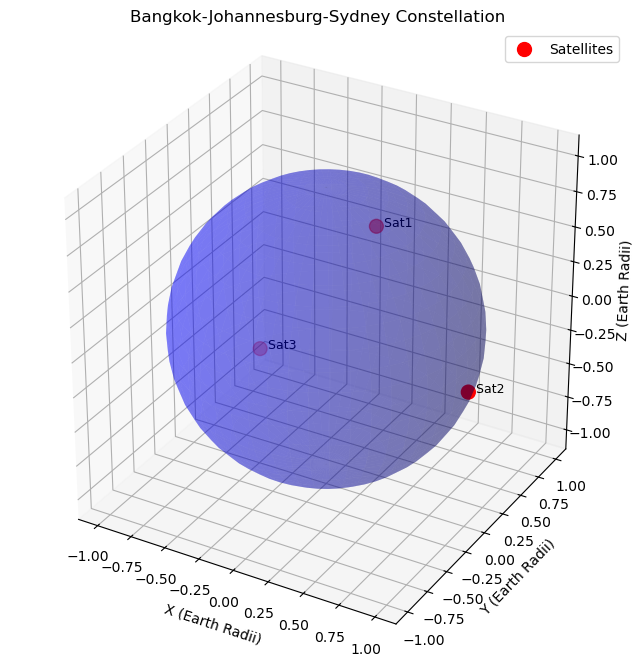


5️⃣ MATRIX ANALYSIS WITH COOL NAMES

🛰️  EFFICIENCY MATRIX
           Surveyor  Orion  Curiosity
Surveyor      1.000  0.239      0.170
Orion         0.239  1.000      0.352
Curiosity     0.170  0.352      1.000

📊 Matrix Statistics:
   Shape: (3, 3)
   Min value: 0.170
   Max value: 1.000
   Mean: 0.503
   Trace (diagonal sum): 3.000
   Largest eigenvalue: 1.516
   Smallest eigenvalue: 0.638

🛰️  COMMUNICATION MATRIX
           Surveyor  Orion  Curiosity
Surveyor      1.000  0.325      0.390
Orion         0.325  1.000      0.252
Curiosity     0.390  0.252      1.000

📊 Matrix Statistics:
   Shape: (3, 3)
   Min value: 0.252
   Max value: 1.000
   Mean: 0.548
   Trace (diagonal sum): 3.000
   Largest eigenvalue: 1.647
   Smallest eigenvalue: 0.596

✅ All tests completed! Try different combinations:
   - generate_satellite_positions(n, 'predefined'|'global'|'regional'|'clustered'|'uniform')
   - generate_satellite_names(n, 'space'|'mythological'|'explorers'|'stars'|'mixed')
   - print_s

In [30]:
# Demo: Test the new satellite generation and naming features

# Generate different types of satellite constellations
print("🚀 TESTING SATELLITE CONSTELLATION GENERATOR")
print("=" * 60)

# Test 1: Predefined global positions (3 satellites)
print("\n1️⃣ PREDEFINED GLOBAL CONSTELLATION (3 satellites)")
global_sats = generate_satellite_positions(3, "predefined", seed=42)
global_names = print_satellite_info(global_sats, title="Global Test Constellation")

# Test 2: Generate cool names with different themes
print("\n2️⃣ TESTING DIFFERENT NAME THEMES")
themes = ["space", "mythological", "explorers", "stars"]
for theme in themes:
    names = generate_satellite_names(4, theme)
    print(f"{theme.capitalize():12s}: {', '.join(names)}")

# Test 3: Different distributions
print("\n3️⃣ TESTING DIFFERENT DISTRIBUTIONS")

# Clustered (high overlap - good for redundancy testing)
clustered_sats = generate_satellite_positions(4, "clustered", seed=123)
clustered_names = print_satellite_info(clustered_sats, title="Clustered Constellation")

# Global well-separated (good for efficiency testing)
global_separated = generate_satellite_positions(4, "global", min_separation=45.0, seed=456)
global_sep_names = print_satellite_info(global_separated, title="Well-Separated Global")

# Regional (good for communication testing)
regional_sats = generate_satellite_positions(4, "regional", min_separation=10.0, seed=789)
regional_names = print_satellite_info(regional_sats, title="Regional Constellation")

# Test 4: Visualize one of the constellations
print("\n4️⃣ VISUALIZING PREDEFINED CONSTELLATION")
visualize_satellites_3d(global_sats, "Bangkok-Johannesburg-Sydney Constellation")

# Test 5: Matrix analysis with named satellites
print("\n5️⃣ MATRIX ANALYSIS WITH COOL NAMES")
weights = {"efficiency": 0.4, "redundancy": 0.3, "communication": 0.3}

# Create matrices
eff_matrix = constraint_matrix(global_sats, "efficiency")
red_matrix = constraint_matrix(global_sats, "redundancy") 
comm_matrix = communication_matrix(global_sats)

# Use the professional formatter with our generated names
format_matrix_professional(eff_matrix, "Efficiency Matrix", global_names)
format_matrix_professional(comm_matrix, "Communication Matrix", global_names)

print("\n✅ All tests completed! Try different combinations:")
print("   - generate_satellite_positions(n, 'predefined'|'global'|'regional'|'clustered'|'uniform')")
print("   - generate_satellite_names(n, 'space'|'mythological'|'explorers'|'stars'|'mixed')")
print("   - print_satellite_info(positions, names, title)")
print("   - Use the names with format_matrix_professional(matrix, name, satellite_names)")

_______________________________________________________________________________________________________________________________


🛰️  NOVATECH CONSTELLATION
Number of satellites: 5
Satellite Details:
--------------------------------------------------
Balder      : (  52.28°,    12.01°) - Europe/Mediterranean (Lat: 52.28°, Lon: 12.01°)
Hera        : (  50.80°,    10.89°) - Europe/Mediterranean (Lat: 50.80°, Lon: 10.89°)
Osiris      : (  48.00°,    13.80°) - Europe/Mediterranean (Lat: 48.00°, Lon: 13.80°)
Ra          : (  48.64°,     7.66°) - Near Paris, France (390km away)
Ares        : (  53.61°,    10.67°) - Europe/Mediterranean (Lat: 53.61°, Lon: 10.67°)

📊 Separation Analysis:
------------------------------
Minimum separation:    1.6°
Maximum separation:    5.9°
Average separation:    3.7°
Std deviation:         1.4°


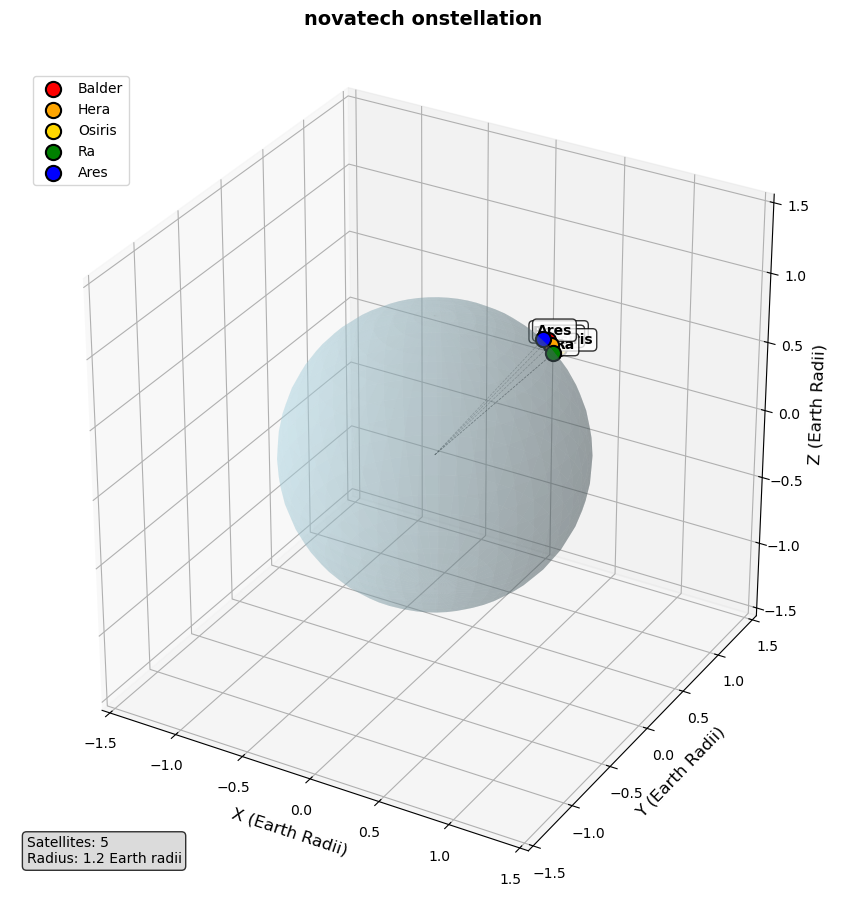


🛰️ novatech onstellation
Balder         : (  52.28°,    12.01°)
Hera           : (  50.80°,    10.89°)
Osiris         : (  48.00°,    13.80°)
Ra             : (  48.64°,     7.66°)
Ares           : (  53.61°,    10.67°)

🛰️  EFFICIENCY
        Balder  Hera  Osiris    Ra  Ares
Balder   1.000 0.000   0.001 0.001 0.000
Hera     0.000 1.000   0.000 0.000 0.000
Osiris   0.001 0.000   1.000 0.001 0.001
Ra       0.001 0.000   0.001 1.000 0.001
Ares     0.000 0.000   0.001 0.001 1.000

📊 Matrix Statistics:
   Shape: (5, 5)
   Min value: 0.000
   Max value: 1.000
   Mean: 0.200
   Trace (diagonal sum): 5.000
   Largest eigenvalue: 1.003
   Smallest eigenvalue: 0.998

🛰️  RDENDNACY
        Balder  Hera  Osiris    Ra  Ares
Balder   1.000 1.000   0.999 0.998 1.000
Hera     1.000 1.000   0.999 0.999 0.999
Osiris   0.999 0.999   1.000 0.999 0.997
Ra       0.998 0.999   0.999 1.000 0.998
Ares     1.000 0.999   0.997 0.998 1.000

📊 Matrix Statistics:
   Shape: (5, 5)
   Min value: 0.997
   Max value:

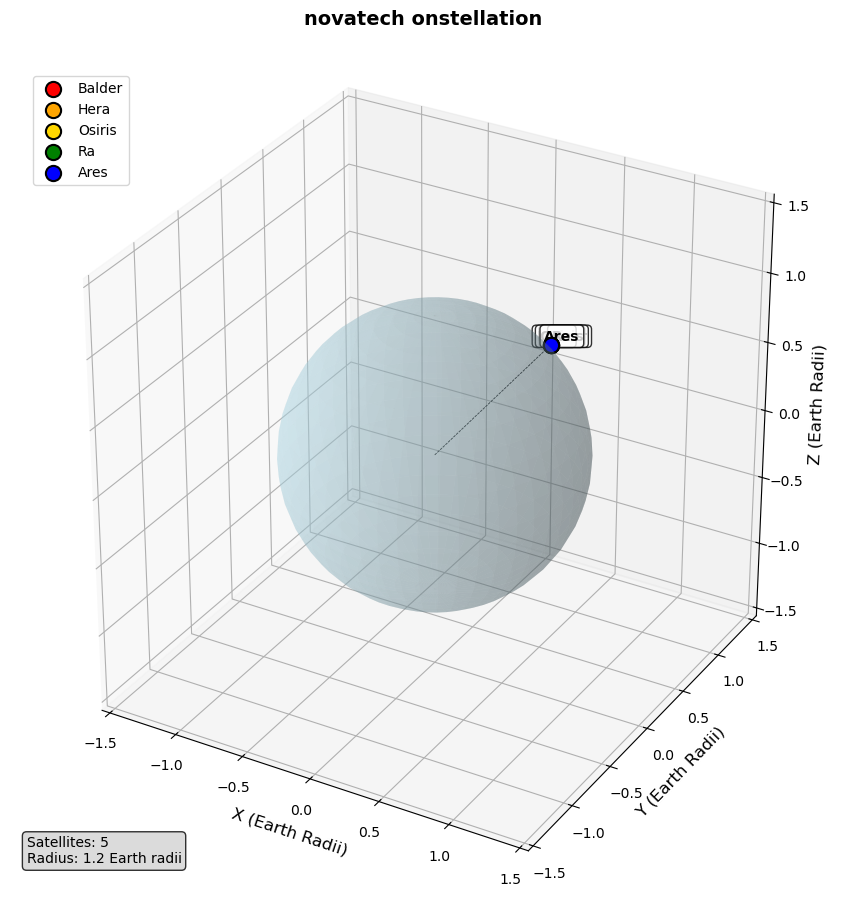


🛰️ novatech onstellation
Balder         : (  50.75°,    11.03°)
Hera           : (  50.75°,    11.03°)
Osiris         : (  50.75°,    11.03°)
Ra             : (  50.75°,    11.03°)
Ares           : (  50.75°,    11.03°)

🛰️  EFFICIENCY
        Balder  Hera  Osiris    Ra  Ares
Balder   1.000 0.000   0.000 0.000 0.000
Hera     0.000 1.000   0.000 0.000 0.000
Osiris   0.000 0.000   1.000 0.000 0.000
Ra       0.000 0.000   0.000 1.000 0.000
Ares     0.000 0.000   0.000 0.000 1.000

📊 Matrix Statistics:
   Shape: (5, 5)
   Min value: 0.000
   Max value: 1.000
   Mean: 0.200
   Trace (diagonal sum): 5.000
   Largest eigenvalue: 1.000
   Smallest eigenvalue: 1.000

🛰️  RDENDNACY
        Balder  Hera  Osiris    Ra  Ares
Balder   1.000 1.000   1.000 1.000 1.000
Hera     1.000 1.000   1.000 1.000 1.000
Osiris   1.000 1.000   1.000 1.000 1.000
Ra       1.000 1.000   1.000 1.000 1.000
Ares     1.000 1.000   1.000 1.000 1.000

📊 Matrix Statistics:
   Shape: (5, 5)
   Min value: 1.000
   Max value:

In [45]:
# ok let's test out my optimisation with some satellites using claudes satellite generator

n_satellites = 5
weights = {"efficiency": 0.5, "redundancy": 0.0, "communication": 0.5 }
test_satellites = generate_satellite_positions(n_satellites, "clustered", seed = 43)
satellite_names = generate_satellite_names(n_satellites, "mythological")

print_satellite_info(test_satellites, satellite_names, "Novatech constellation")
visualize_satellites_3d(test_satellites, "novatech onstellation", satellite_names)
format_matrix_professional(constraint_matrix(test_satellites,"efficiency"), "Efficiency", satellite_names)
format_matrix_professional(constraint_matrix(test_satellites,"redundancy"), "Rdendnacy", satellite_names)
format_matrix_professional(communication_matrix(test_satellites), "Communication", satellite_names)

optimised_satellites = optimise_satellite_positions(test_satellites, weights)

print_satellite_info(optimised_satellites, satellite_names, "Novatech constellation")
visualize_satellites_3d(optimised_satellites, "novatech onstellation", satellite_names)
format_matrix_professional(constraint_matrix(optimised_satellites,"efficiency"), "Efficiency", satellite_names)
format_matrix_professional(constraint_matrix(optimised_satellites,"redundancy"), "Rdendnacy", satellite_names)
format_matrix_professional(communication_matrix(optimised_satellites), "Communication", satellite_names)



In [ ]:
# Testing communcatiion matricies for different configurations 

In [6]:
# Define constraints for optimisation

def coverage_matrix(theta):
    """Coverage quality matrix based on satellite separation angle theta."""
    overlap = np.cos(theta/2)  # More overlap when satellites are closer
    return np.array([[1.0, overlap],
                     [overlap, 1.0]])

def redundancy_matrix(theta):
    """Redundancy matrix - we WANT some overlap for failure tolerance."""
    overlap = np.cos(theta/2)
    redundancy = overlap**2  # Quadratic penalty for no redundancy
    return np.array([[redundancy, overlap],
                     [overlap, redundancy]])

def communication_matrix(theta):
    """Inter-satellite communication quality matrix."""
    # Communication quality decreases with distance
    # But too close satellites interfere with each other
    distance = abs(theta)
    if distance > np.pi:
        distance = 2*np.pi - distance  # Wrap around for shorter arc
    
    # Optimal communication at medium distances
    comm_quality = np.exp(-(distance - np.pi/2)**2)  # Peak at 90° separation
    return np.array([[0, comm_quality],
                     [comm_quality, 0]])

def combined_matrix(theta, w_coverage=0.6, w_redundancy=0.3, w_comm=0.1):
    """Weighted combination of all constraint matrices."""
    C_cov = coverage_matrix(theta)
    C_red = redundancy_matrix(theta)
    C_comm = communication_matrix(theta)
    
    return w_coverage * C_cov + w_redundancy * C_red + w_comm * C_comm


In [7]:

def objective_function(theta, weights=(0.6, 0.3, 0.1)):
    """Objective: maximize minimum eigenvalue of combined system."""
    C = combined_matrix(theta, *weights)
    eigenvals = np.linalg.eigvals(C)
    return -np.min(eigenvals)  # Negative because we want to maximize

def analyze_constellation():
    """Analyze how constellation performance varies with satellite separation."""
    
    # Grid search across all possible separations
    thetas = np.linspace(0, 2*np.pi, 1000)
    objectives = []
    min_eigenvals = []
    max_eigenvals = []
    
    for theta in thetas:
        C = combined_matrix(theta)
        eigenvals = np.linalg.eigvals(C)
        eigenvals = np.sort(eigenvals)
        
        objectives.append(-objective_function(theta))
        min_eigenvals.append(eigenvals[0])
        max_eigenvals.append(eigenvals[1])
    
    # Find optimal configuration
    optimal_idx = np.argmax(objectives)
    optimal_theta = thetas[optimal_idx]
    optimal_performance = objectives[optimal_idx]
    
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Overall objective function
    ax1.plot(thetas * 180/np.pi, objectives, 'b-', linewidth=2, label='Combined Objective')
    ax1.axvline(optimal_theta * 180/np.pi, color='r', linestyle='--', 
                label=f'Optimal: {optimal_theta*180/np.pi:.1f}°')
    ax1.set_xlabel('Satellite Separation (degrees)')
    ax1.set_ylabel('System Performance')
    ax1.set_title('Multi-Constraint Optimization Result')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Eigenvalue spectrum
    ax2.plot(thetas * 180/np.pi, min_eigenvals, 'r-', linewidth=2, label='Min Eigenvalue')
    ax2.plot(thetas * 180/np.pi, max_eigenvals, 'g-', linewidth=2, label='Max Eigenvalue')
    ax2.axvline(optimal_theta * 180/np.pi, color='black', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Satellite Separation (degrees)')
    ax2.set_ylabel('Eigenvalue')
    ax2.set_title('Eigenvalue Spectrum Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Individual constraint contributions
    coverage_objs = [-np.min(np.linalg.eigvals(coverage_matrix(theta))) for theta in thetas]
    redundancy_objs = [-np.min(np.linalg.eigvals(redundancy_matrix(theta))) for theta in thetas]
    comm_objs = [-np.min(np.linalg.eigvals(communication_matrix(theta))) for theta in thetas]
    
    ax3.plot(thetas * 180/np.pi, coverage_objs, 'b-', label='Coverage', linewidth=2)
    ax3.plot(thetas * 180/np.pi, redundancy_objs, 'orange', label='Redundancy', linewidth=2)
    ax3.plot(thetas * 180/np.pi, comm_objs, 'green', label='Communication', linewidth=2)
    ax3.axvline(optimal_theta * 180/np.pi, color='r', linestyle='--', alpha=0.7)
    ax3.set_xlabel('Satellite Separation (degrees)')
    ax3.set_ylabel('Individual Performance')
    ax3.set_title('Individual Constraint Analysis')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Configuration visualization
    ax4.set_xlim(-1.5, 1.5)
    ax4.set_ylim(-1.5, 1.5)
    
    # Draw Earth
    earth = plt.Circle((0, 0), 1, fill=False, color='blue', linewidth=3)
    ax4.add_patch(earth)
    
    # Draw optimal satellite positions
    sat1_x, sat1_y = 1.3 * np.cos(0), 1.3 * np.sin(0)
    sat2_x, sat2_y = 1.3 * np.cos(optimal_theta), 1.3 * np.sin(optimal_theta)
    
    ax4.plot(sat1_x, sat1_y, 'ro', markersize=10, label='Satellite 1')
    ax4.plot(sat2_x, sat2_y, 'go', markersize=10, label='Satellite 2')
    
    # Draw coverage areas (simplified)
    coverage1 = plt.Circle((sat1_x, sat1_y), 0.5, alpha=0.3, color='red')
    coverage2 = plt.Circle((sat2_x, sat2_y), 0.5, alpha=0.3, color='green')
    ax4.add_patch(coverage1)
    ax4.add_patch(coverage2)
    
    # Draw communication link
    ax4.plot([sat1_x, sat2_x], [sat1_y, sat2_y], 'k--', alpha=0.7, linewidth=2)
    
    ax4.set_aspect('equal')
    ax4.set_title(f'Optimal Configuration: {optimal_theta*180/np.pi:.1f}° Separation')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print optimization results
    print("🛰️ CONSTELLATION OPTIMIZATION RESULTS")
    print("=" * 50)
    print(f"Optimal satellite separation: {optimal_theta*180/np.pi:.1f}°")
    print(f"System performance score: {optimal_performance:.3f}")
    print(f"Performance at 0° (same position): {-objective_function(0):.3f}")
    print(f"Performance at 180° (opposite): {-objective_function(np.pi):.3f}")
    print(f"Performance at 90° (perpendicular): {-objective_function(np.pi/2):.3f}")
    
    # Analyze optimal configuration
    C_optimal = combined_matrix(optimal_theta)
    eigenvals_optimal = np.linalg.eigvals(C_optimal)
    print(f"\nOptimal configuration eigenvalues: {eigenvals_optimal}")
    print(f"Minimum eigenvalue (bottleneck): {np.min(eigenvals_optimal):.3f}")
    
    return optimal_theta, optimal_performance


In [11]:
analyze_constellation()

NameError: name 'analyze_constellation' is not defined